In [5]:
import numpy as np
import pandas as pd
import re
import pymorphy2
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from stopwords import sw
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [6]:
def preprocess_unlabeled_train(data):
    data.columns = ["sentence", "book", "author"]
    
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[\?]", " ? ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[\!]", " ! ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я\!\?]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    why_cant_pd_drop_just_work_omg = data.pop("book")
    why_cant_pd_drop_just_work_omg = data.pop("author")
    
    data["label"] = np.zeros((data.shape[0], ), dtype=np.int8) - 1
    
    return data

def preprocess_labeled(data):
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[\?]", " ? ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[\!]", " ! ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я\?\!]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    label = lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}.get(x)
    data.label = list(map(label, data.label))
    
    return data

def vectorize(data):
    vocab = uvocab | lvocab | tvocab
    model = TfidfVectorizer(vocabulary=vocab)
    matrix = model.fit_transform(list(map(lambda x: " ".join(x), data.sentence)))
    return matrix.todense()

def preprocess_unlabeled_test(data):
    data.columns = ["sentence"]
    
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[\?]", " ? ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[\!]", " ! ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я\!\?]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    data["label"] = np.zeros((data.shape[0], ), dtype=np.int8) - 1
    
    return data

def make_csv(cluster_ids):
    unlabel = lambda x: {0: 'negative', 1: 'neutral', 2: 'positive'}.get(x)
    pred = pd.DataFrame(list(map(unlabel, cluster_ids)), columns=["label"])
    #pred["label"] = list(map(lambda x: "\"" + x + "\"", pred["label"]))
    pred.to_csv("answer.csv", index=False)

def vectorize_w2v(data):
    matrix = []
    for doc in data.sentence:
        docvec = []
        for word in doc:
            try:
                docvec.append(word_vectors[word])
            except KeyError:
                pass
        if docvec:
            docvec = np.mean(docvec, axis=0)
        else:
            docvec = np.zeros((300,))
        matrix.append(docvec)
    return np.array(matrix)

In [9]:
data_unlabeled = pd.read_csv("sentences.csv")
data_labeled = pd.read_excel("labeled_sentences.xlsx")
data_test = pd.read_csv("/Users/alexajax/Downloads/dataset_38921_3.txt")

In [10]:
data_unlabeled

,Предложение,Название произведения,Номер автора
0,﻿– Так ты приходи!,Гостинец,0
1,"– в третий раз попросил Сениста, и в третий ра...",Гостинец,0
2,"Еще бы не прийти, конечно прийду.",Гостинец,0
3,И снова они замолчали.,Гостинец,0
4,"Сениста лежал на спине, до подбородка укрытый ...",Гостинец,0
...,...,...,...
2992,Он представляет себе тоненькую фигуру Нины с д...,Весенний ветер,19
2993,"Он видит даже, как встряхивает она головкой, и...",Весенний ветер,19
2994,"Пышные небывающие розы протягивают ему букеты,...",Весенний ветер,19
2995,Колышащиеся связки шаров гибко выгибаются к не...,Весенний ветер,19


In [8]:
data_unlabeled = preprocess_unlabeled_train(data_unlabeled)
data_labeled = preprocess_labeled(data_labeled)
data_test = preprocess_unlabeled_test(data_test)

2021-04-11 14:31:06,162 : INFO : Loading dictionaries from /Users/alexajax/anaconda3/lib/python3.8/site-packages/pymorphy2_dicts_ru/data
2021-04-11 14:31:06,206 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345
2021-04-11 14:31:18,851 : INFO : Loading dictionaries from /Users/alexajax/anaconda3/lib/python3.8/site-packages/pymorphy2_dicts_ru/data
2021-04-11 14:31:18,896 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345
2021-04-11 14:31:21,340 : INFO : Loading dictionaries from /Users/alexajax/anaconda3/lib/python3.8/site-packages/pymorphy2_dicts_ru/data
2021-04-11 14:31:21,379 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [135]:
gb = data_labeled.groupby("label")

idf_counts = Counter()
for row in data_labeled.itertuples():
    idf_counts.update(row.sentence)
        
for group in gb.groups:
    print (group)
    
    counts = Counter()
    for row in gb.get_group(group).itertuples():
        counts.update(row.sentence)
    
    for k,v in counts.items():
        counts[k] =  v / (idf_counts[k])
    
    print (counts.most_common(200))

0
[('носов', 1.0), ('озоровать', 1.0), ('вор', 1.0), ('постоять', 1.0), ('через', 1.0), ('колодезь', 1.0), ('писаться', 1.0), ('заводиться', 1.0), ('сечь', 1.0), ('лопотать', 1.0), ('слушай', 1.0), ('пыльный', 1.0), ('ребятишки', 1.0), ('морщиться', 1.0), ('отравить', 1.0), ('живо', 1.0), ('сырость', 1.0), ('стыдиться', 1.0), ('первостепенный', 1.0), ('вскипеть', 1.0), ('воспоминание', 1.0), ('волей', 1.0), ('иль', 1.0), ('ак', 1.0), ('болтун', 1.0), ('лаять', 1.0), ('похоронить', 1.0), ('индианка', 1.0), ('напустить', 1.0), ('дурачина', 1.0), ('скука', 1.0), ('притворяться', 1.0), ('тьфу', 1.0), ('голов', 1.0), ('отвалять', 1.0), ('скотский', 1.0), ('пропивать', 1.0), ('грие', 1.0), ('таинственно', 1.0), ('интерес', 1.0), ('ище', 1.0), ('соскочить', 1.0), ('шалить', 1.0), ('клясться', 1.0), ('злодей', 1.0), ('надеть', 1.0), ('долой', 1.0), ('посудить', 1.0), ('слышаться', 1.0), ('де', 1.0), ('ползать', 1.0), ('гардероб', 1.0), ('алка', 1.0), ('фу', 1.0), ('тоня', 1.0), ('проклятый', 1

In [264]:
Y = data_labeled.pop("label")

In [265]:
umodel = TfidfVectorizer()
umatrix = umodel.fit_transform(list(map(lambda x: " ".join(x), data_unlabeled.sentence)))
uvocab = set(umodel.vocabulary_.keys())

lmodel = TfidfVectorizer()
lmatrix = lmodel.fit_transform(list(map(lambda x: " ".join(x), data_labeled.sentence)))
lvocab = set(lmodel.vocabulary_.keys())

tmodel = TfidfVectorizer()
tmatrix = tmodel.fit_transform(list(map(lambda x: " ".join(x), data_test.sentence)))
tvocab = set(tmodel.vocabulary_.keys())

In [266]:
labeled_matrix = vectorize(data_labeled)
unlabeled_matrix = vectorize(data_unlabeled)
test_matrix = vectorize(data_test)

In [152]:
pca = PCA(n_components=200).fit(np.concatenate([labeled_matrix,unlabeled_matrix,test_matrix]))

lmc = pca.transform(labeled_matrix)
tmc = pca.transform(test_matrix)

In [165]:
tmc = pca.transform(test_matrix)

In [267]:
Counter(Y)

Counter({0: 260, 1: 1475, 2: 130})

In [170]:
#X_train, X_test, Y_train, Y_test = train_test_split(lmc, Y, test_size=0.3, random_state=42)

## Random Forest

In [268]:
rf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)
%time rf.fit(labeled_matrix, Y)

CPU times: user 19min 31s, sys: 9.86 s, total: 19min 40s
Wall time: 2min 46s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [269]:
rf_cluster_ids = rf.predict(test_matrix)

In [270]:
rf_cluster_ids

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [271]:
make_csv(rf_cluster_ids)

## Repustate

In [60]:
result = pd.read_csv("/Users/alexajax/Downloads/repustate-results.csv")

In [61]:
def ev(x):
    if x < 0:
        return 0
    if x == 0:
        return 1
    if x > 0:
        return 2

In [62]:
result = result[result.Text != "sentence"]

In [63]:
make_csv(list(map(ev, result.Sentiment.values)))

In [75]:
Counter(data_labeled["label"][data_labeled["sentence"].apply(lambda s : "?" in s)])

Counter({'negative': 21, 'neutral': 448, 'positive': 7})

## Indico

In [35]:
import indicoio

In [36]:
indicoio.config.api_key = '99d25f7b6d9a122fa38fb64233a48f7f'

In [39]:
data_labeled

,sentence,label
0,-- То-то -- бедная!,neutral
1,-- Куда же приехали-то?,neutral
2,-- Когда бог судить-то будет?,neutral
3,"-- А коли высечешь, значит, и не отвергнешь!",neutral
4,-- А где одёжу возьмёшь?,neutral
5,"-- Нимало: не все равно играть, что там, что у...",neutral
6,"-- А вот что я скажу тебе, Ваня, -- решил стар...",neutral
7,-- Чего изволите?,neutral
8,"-- Нет, маменька, не надо.",neutral
9,-- В поле -- очень!,neutral


In [41]:
labeled_indico = indicoio.sentiment(list(data_labeled.sentence.values))

In [86]:
np.array(labeled_indico)[data_labeled.label.values=="positive"].mean(),np.array(labeled_indico)[data_labeled.label.values=="negative"].mean()

(0.47711443481692312, 0.46750826373307691)

(array([ 116.,  159.,  195.,  185.,  183.,  178.,  129.,  139.,  112.,   79.]),
 array([ 0.00164797,  0.10093526,  0.20022255,  0.29950984,  0.39879713,
         0.49808441,  0.5973717 ,  0.69665899,  0.79594628,  0.89523357,
         0.99452085]),
 <a list of 10 Patch objects>)

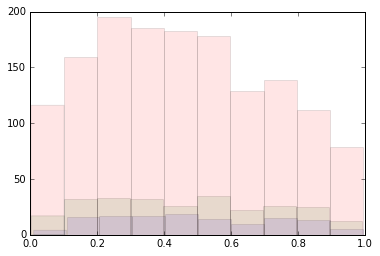

In [83]:
plt.hist(
    np.array(labeled_indico)[data_labeled.label.values=="positive"],alpha=0.1
    )

plt.hist(
    np.array(labeled_indico)[data_labeled.label.values=="negative"],alpha=0.1
    )

plt.hist(
    np.array(labeled_indico)[data_labeled.label.values=="neutral"],alpha=0.1
    )

## W2V

In [136]:
from gensim.models.word2vec import Word2Vec

In [139]:
w2vmodel = Word2Vec.load_word2vec_format("/Users/alexajax/Downloads/ruscorpora.model.bin", binary=True)

In [142]:
word_vectors = {}

for word in (uvocab | lvocab | tvocab):
    try:
        word_vectors[word] = w2vmodel[word]
    except KeyError:
        pass

In [145]:
len(word_vectors)/len(uvocab | lvocab | tvocab)

0.8483646301683858

In [254]:
labeled_matrix_w2v = vectorize_w2v(data_labeled)
unlabeled_matrix_w2v = vectorize_w2v(data_unlabeled)
test_matrix_w2v = vectorize_w2v(data_test)

In [255]:
rf_w2v = RandomForestClassifier(n_estimators=3000, n_jobs=-1)
%time rf_w2v.fit(labeled_matrix_w2v, Y)

CPU times: user 1min 42s, sys: 909 ms, total: 1min 43s
Wall time: 16.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [256]:
rf_cluster_ids_w2v = rf_w2v.predict(test_matrix_w2v)

In [257]:
rf_cluster_ids_w2v

array([0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [259]:
make_csv(rf_cluster_ids_w2v)